# Plots for BSC

In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(ref_dir='../references/lcdb-references')

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2019-02-20 
Git hash: 2db29778708209bb252d7237edb7fb6db71d3f3a


In [3]:
# Connect to data store
store = pd.HDFStore('../output/sra.h5', mode='r')

In [4]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sramongo']
ncbi = db['ncbi']

In [5]:
df = (
    pd.DataFrame(list(
        ncbi.aggregate([
            {'$unwind': {'path': '$runs'}},
            {
                '$project': {
                    '_id': False,
                    'srx': '$srx',
                    'srr': '$runs.srr',
                    'date': '$runs.load_date',
                    'size_MB': '$runs.size_MB'
                }
            },
        ])
    ))
    .set_index(['srx', 'srr'])
    .assign(date=lambda df: pd.to_datetime(df.date))
    .sort_values('date')
    .assign(cum_sum_TB = lambda df: df.size_MB.cumsum() / 1e6)
    .assign(year=lambda df: df.date.dt.year)
    .dropna()
    .assign(year=lambda df: df.year.astype(int))
)

In [8]:
df.head()

,,date,size_MB,cum_sum_TB,year
srx,srr,,,,
SRX109742,SRR385904,2012-01-11 13:51:17,21,0.000021,2012
SRX109669,SRR385892,2012-01-11 13:51:22,35,0.000056,2012
SRX109670,SRR385893,2012-01-11 13:51:22,32,0.000088,2012
SRX109739,SRR385901,2012-01-11 13:51:23,23,0.000111,2012
SRX109671,SRR385894,2012-01-11 13:51:23,36,0.000147,2012


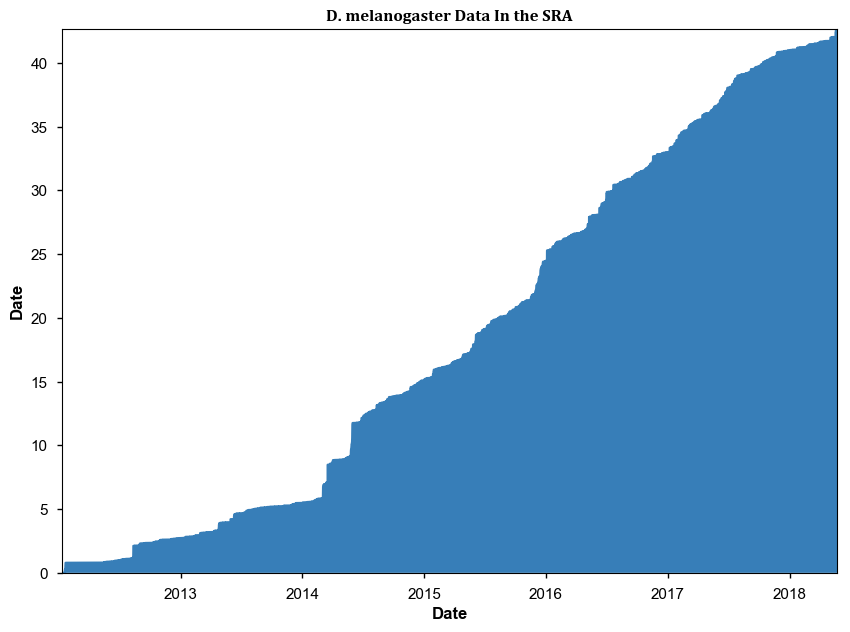

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
df.plot('date', 'cum_sum_TB', ax=ax, legend=False)
ax.fill_between(df.date.dt.to_pydatetime(), 0, df['cum_sum_TB'])
ax.margins(0)
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Date', fontweight='bold')
ax.set_title('D. melanogaster Data In the SRA', fontweight='bold', family='Cambria')
fig.autofmt_xdate(rotation=0, ha='center')

In [21]:
strategy = (
    pd.read_parquet('../output/metadata-wf/select_library_strategy.parquet')
    .rename(columns={'Fear_et_al_library_strategy': 'library_strategy'})
    .library_strategy
    .pipe(lambda x: x[~x.str.contains('\|')])
    #.pipe(lambda x: x[x.isin(['RNA-Seq', 'WGS'])])
)

In [47]:
feature_names = (
    pd.read_csv('../output/metadata-wf/random_forest_library_strategy_feature_importance.tsv', sep='\t', header=None, names=['feature', 'importance'])
    .sort_values('importance', ascending=False)
    .head(10)
    .feature
    .values
    .tolist()
)

In [48]:
data = (
    pd.read_parquet('../output/metadata-wf/build_library_strategy_feature_set.parquet', columns=feature_names)
    .join(strategy, how='inner')
)

In [49]:
url = '../output/notebook/2019-02-19_lib_strat_features.json'
data.sample(1_000).to_json(url, orient='records')

In [50]:
def test_theme():
    return {
        'config': {
            'axis': {
                'titleFont': 'Arial',
                'titleFontSize': 8,
                'labelFont': 'Arial',
                'labelFontSize': 3,
            },
            'title': {
                'font': 'Cambria',
                'fontSize': 8
            }
        }
    }

alt.themes.register('test_theme', test_theme)
alt.themes.enable('test_theme')

ThemeRegistry.enable('test_theme')

In [55]:
chart = (
    alt.Chart(url)
    .mark_circle()
    .encode(
        alt.X(alt.repeat('column'), type='quantitative'),
        alt.Y(alt.repeat('row'), type='quantitative'),
        color=alt.Color('library_strategy:N', legend=alt.Legend(title='Library Strategy'))
    )
    .properties(
        width=90,
        height=90
    )
    .repeat(
        column=feature_names,
        row=feature_names
    )
)

In [58]:
chart.savechart('~/Downloads/test.png', format='png')

WebDriverException: Message: 'chromedriver' executable needs to be in PATH. Please see https://sites.google.com/a/chromium.org/chromedriver/home
